In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

from pathlib import Path
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
from sympy import Point, Polygon
from utils import *

import pandas as pd

/home/khoa-ys/Projects/venv_for_projects/bio_ml_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load dataset and visualize class distribution

In [2]:
root_path = os.path.dirname(os.getcwd())

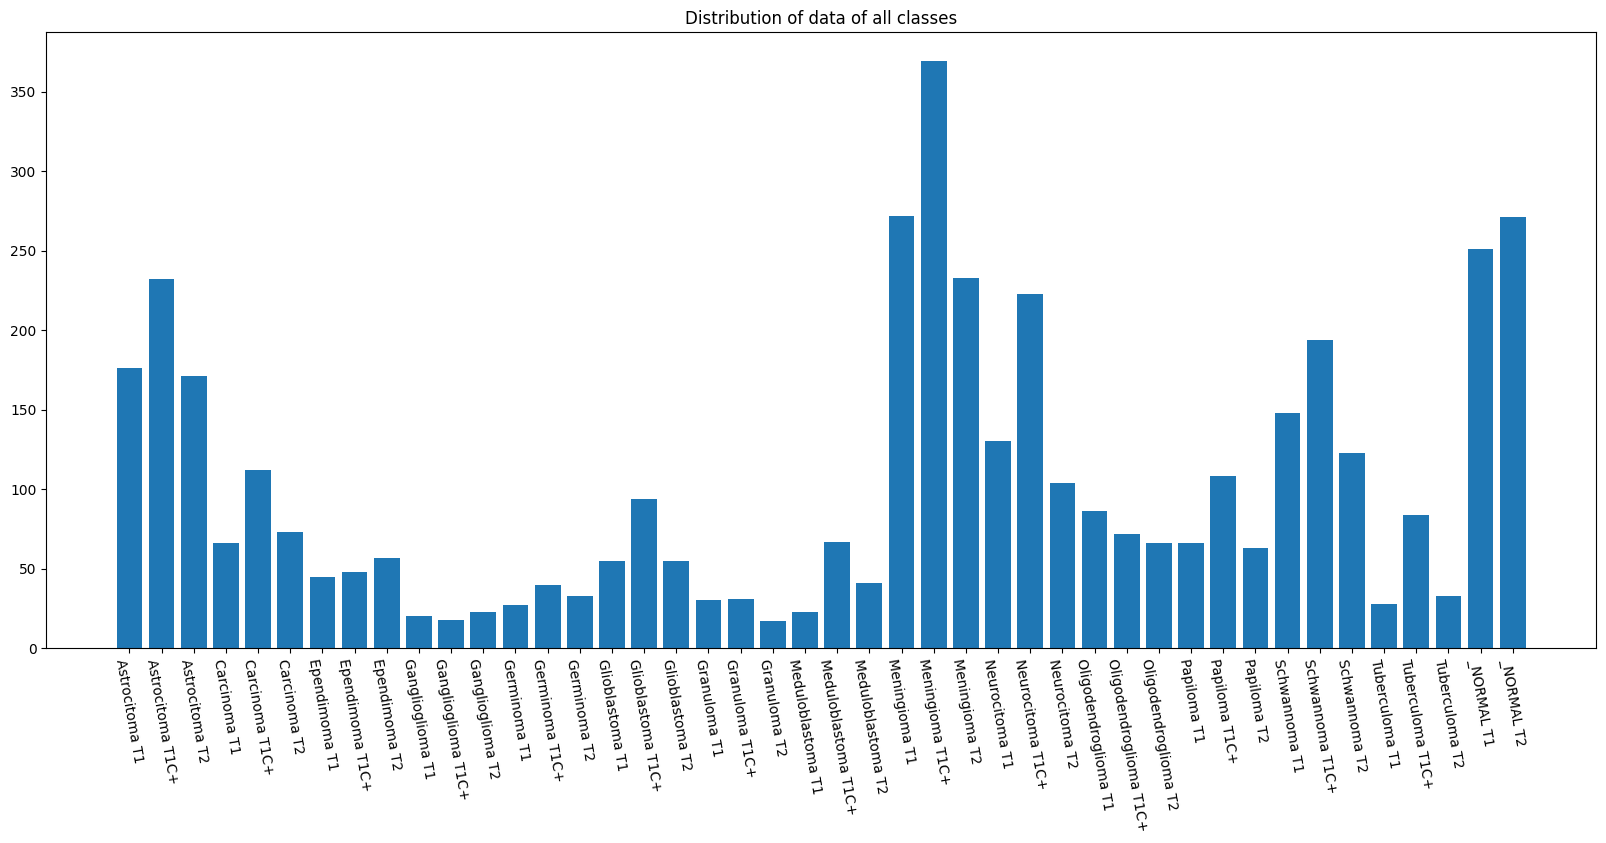

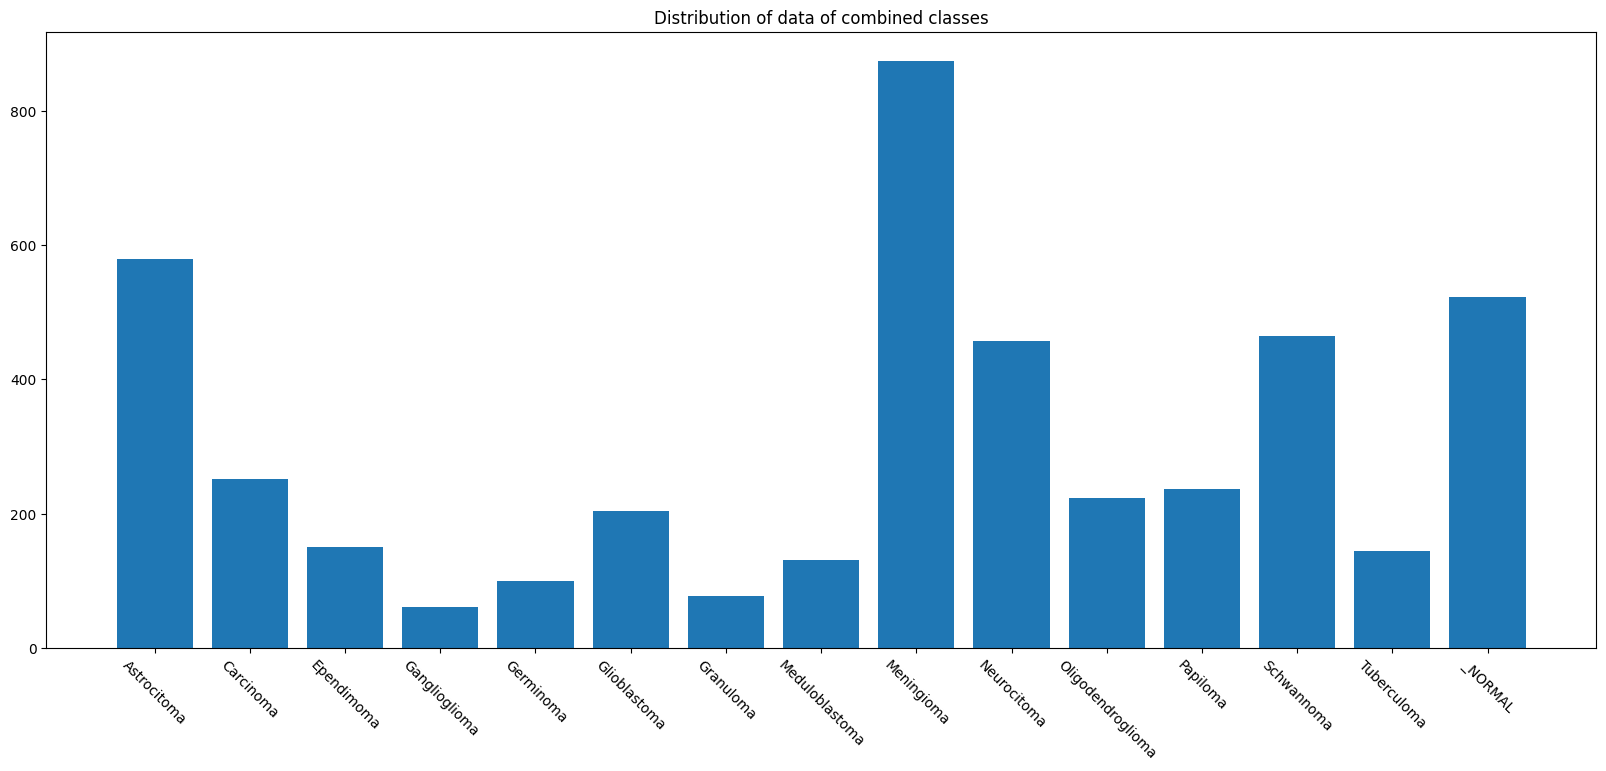

In [3]:
data_path = os.path.join(root_path, "brain_tumor_44_classes")
image_list = [data_path + "/" + folder_name + "/" + fname 
                     for folder_name in os.listdir(data_path)
                     if os.path.isdir(data_path + "/" + folder_name)
                     for fname in os.listdir(data_path+ "/" + folder_name)]
cluster_labels = []
shortened_cluster_labels = []
for folder_name in os.listdir(data_path):
    if os.path.isdir(data_path + "/" + folder_name):
        for fname in os.listdir(data_path+ "/" + folder_name):
            shortened_cluster_labels.append(folder_name.split(" ")[0])
            cluster_labels.append(folder_name)

label_dict = dict(zip(np.unique(cluster_labels), range(1, len(cluster_labels)+2)))
modified_class = [label_dict[label] for label in cluster_labels]
count = np.unique(modified_class, return_counts=True)
plt.figure(figsize=(20, 8))
plt.bar(count[0], count[1])
plt.xticks(list(label_dict.values()), list(label_dict.keys()))
plt.xticks(rotation=-80)
plt.title("Distribution of data of all classes")
plt.show()

shortened_label_dict = dict(zip(np.unique(shortened_cluster_labels), range(1, len(shortened_cluster_labels)+2)))
shortened_modified_class = [shortened_label_dict[label] for label in shortened_cluster_labels]
count = np.unique(shortened_modified_class, return_counts=True)
plt.figure(figsize=(20, 8))
plt.bar(count[0], count[1])
plt.xticks(list(shortened_label_dict.values()), list(shortened_label_dict.keys()))
plt.xticks(rotation=-45)
plt.title("Distribution of data of combined classes")
plt.show()

### Class imbalance:

With great class imbalance, we plan to:  
+ Firstly combine the images belong to the same superclass  
+ Secondly choose only those with more than 140 images  
+ Cut short of the number of images from dominant superclasses

In [4]:
count_modified_class = list({i:shortened_modified_class.count(i) for i in shortened_modified_class}.items())
chosen_class = [key for key in shortened_label_dict for k, v in count_modified_class if shortened_label_dict[key] == k if v >= 150]
print(chosen_class)

shortened_cluster_labels = []
image_dict = {}
i = 0
count = 0
for folder_name in os.listdir(data_path):
    if os.path.isdir(data_path + "/" + folder_name):
        if folder_name.split(" ")[0] in chosen_class:
            current_class = chosen_class.index(folder_name.split(" ")[0])
            #print("current class:", current_class)
            #print("i:", i)
            if current_class != i:
                i = current_class
                #print("New i:", i)
                count = 0
            for fname in os.listdir(data_path+ "/" + folder_name):
                if count < 300:
                    if folder_name.split(" ")[0] not in image_dict:
                        image_dict[folder_name.split(" ")[0]] = [folder_name + "/" + fname]
                    else:
                        image_dict[folder_name.split(" ")[0]].append(folder_name + "/" + fname)
                    shortened_cluster_labels.append(folder_name.split(" ")[0])
                count += 1

['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Glioblastoma', 'Meningioma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', '_NORMAL']


### Resize all chosen images to equal size, reduce border area, and move them to a different folder

In [5]:
new_data_path = os.path.join(root_path, "shortened_dataset")
if not os.path.exists(new_data_path):
    os.mkdir(new_data_path)
    
new_image_dict = {}
for i in range(len(image_dict.keys())):
    tumor_type = list(image_dict.keys())[i]
    new_name_list = []
    for image_name in image_dict[tumor_type]:
        image_path = os.path.join(data_path, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Reduce border area
        ret, thresh = cv2.threshold(image, 20, 255, cv2.THRESH_BINARY)
        contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE,
                                                  method=cv2.CHAIN_APPROX_NONE)

        blank = image.copy()
        contours = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(np.array(contours))
        filtered_image = blank[y: y + h, x: x + w].copy()
        resized_image = cv2.resize(filtered_image, (256, 256))
        
        dest = os.path.join(new_data_path, image_name.split('/')[0].split(' ')[0])
        if not os.path.exists(dest):
            os.mkdir(dest)
        if 'jpeg' in image_name.split('/')[1]:
            new_image_name = image_name.split('/')[1][:-5]+'.png'
        else:
            new_image_name = image_name.split('/')[1][:-4]+'.png'
        
        cv2.imwrite(os.path.join(dest, new_image_name), resized_image)
        new_name_list.append(image_name.split('/')[0].split(' ')[0] + '/' + new_image_name)
    new_image_dict[tumor_type] = new_name_list
    
json.dump(new_image_dict, open(os.path.join(new_data_path, "image_dict.json"), "w"))

/media/khoa-ys/Personal/Projects/ML in Bioinformatics/brain-tumor-classification/src/utils.py:66: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


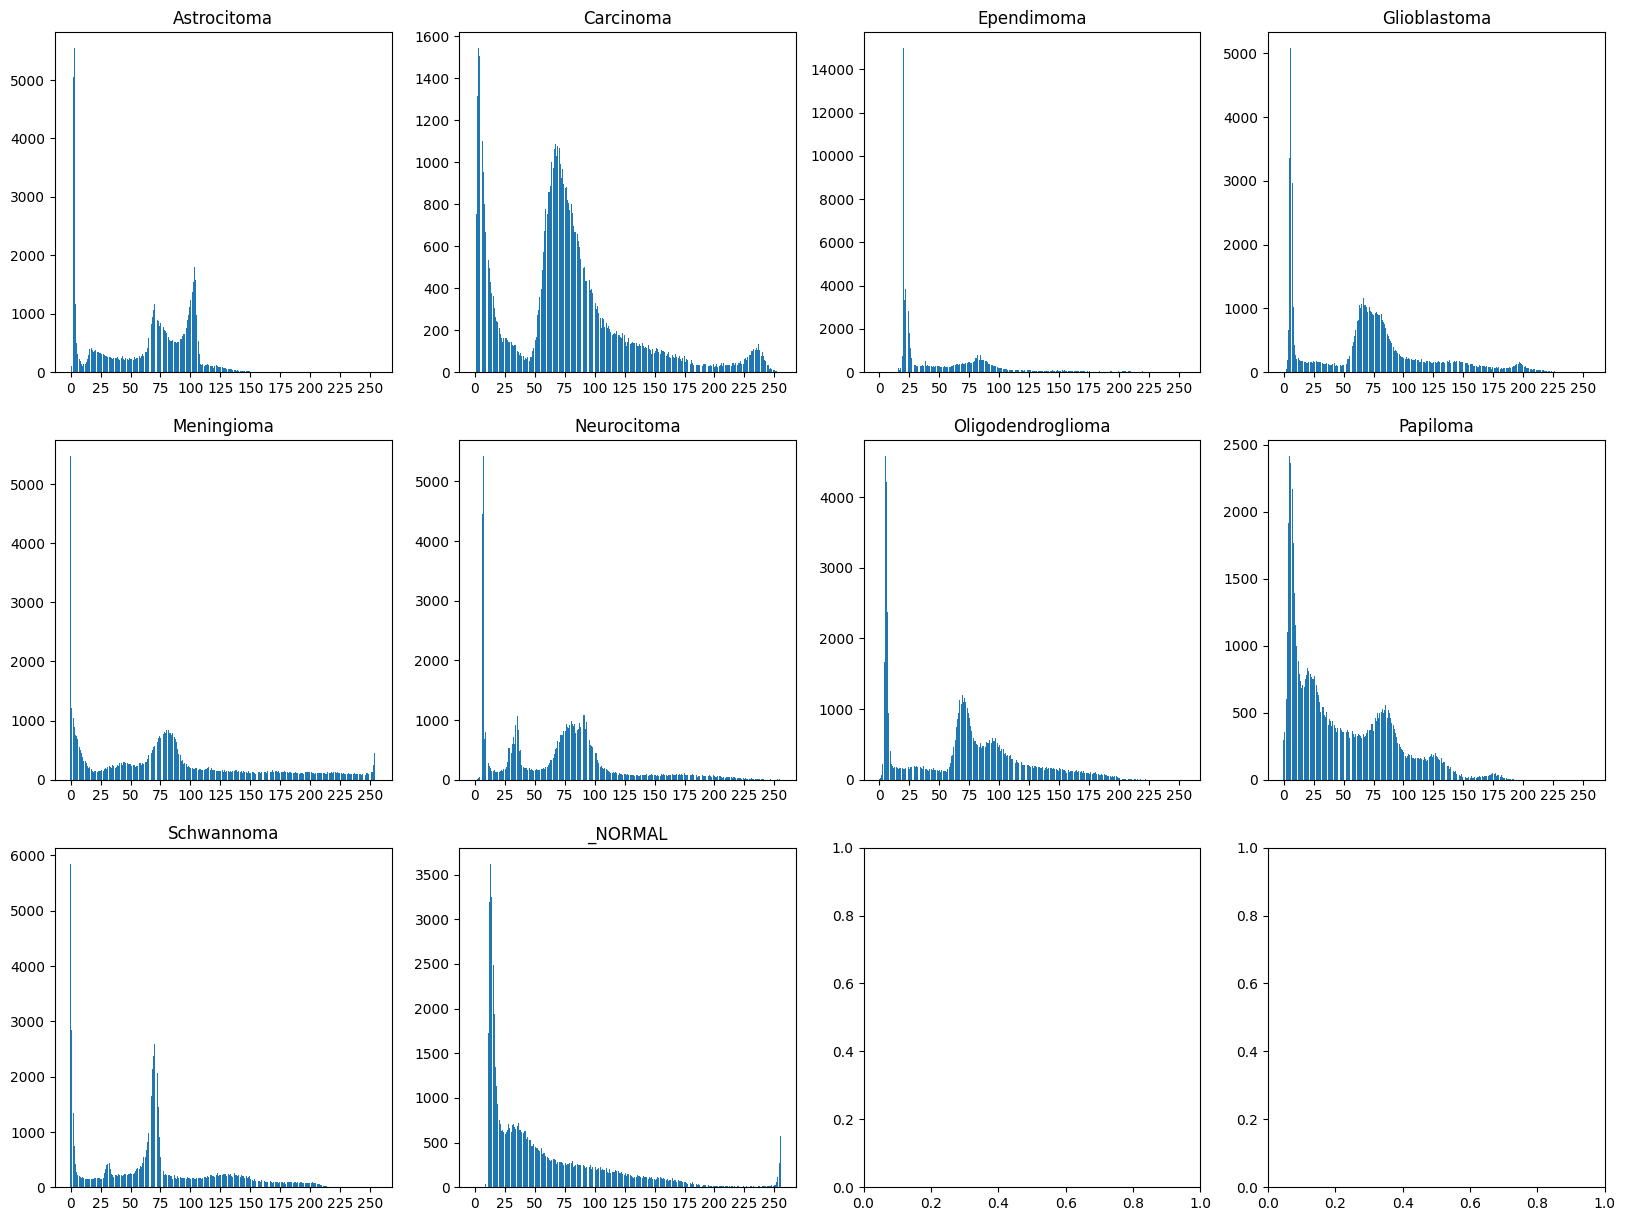

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [6]:
data_path = os.path.join(root_path, "shortened_dataset")
image_dict = json.load(open(os.path.join(data_path, 'image_dict.json'), 'r'))
visualize_histogram_per_class(image_dict, data_path)

### Data augmentations

#### Contrast stretching

In [7]:
data_path = new_data_path
image_dict = new_image_dict

new_data_path = os.path.join(root_path, "contrast_streched_shortened_dataset")
if not os.path.exists(new_data_path):
    os.mkdir(new_data_path)
    
new_image_dict = {}
for i in range(len(image_dict.keys())):
    tumor_type = list(image_dict.keys())[i]
    new_name_list = []
    for image_name in image_dict[tumor_type]:
        image_path = os.path.join(data_path, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        contrasted_image = contrast_stretching(image)
        
        dest = os.path.join(new_data_path, image_name.split('/')[0].split(' ')[0])
        if not os.path.exists(dest):
            os.mkdir(dest)
            
        new_image_name = image_name.split('/')[1]
        
        cv2.imwrite(os.path.join(dest, new_image_name), contrasted_image)
        new_name_list.append(image_name.split('/')[0] + '/' + new_image_name)
    new_image_dict[tumor_type] = new_name_list

json.dump(new_image_dict, open(os.path.join(new_data_path, "image_dict.json"), "w"))    

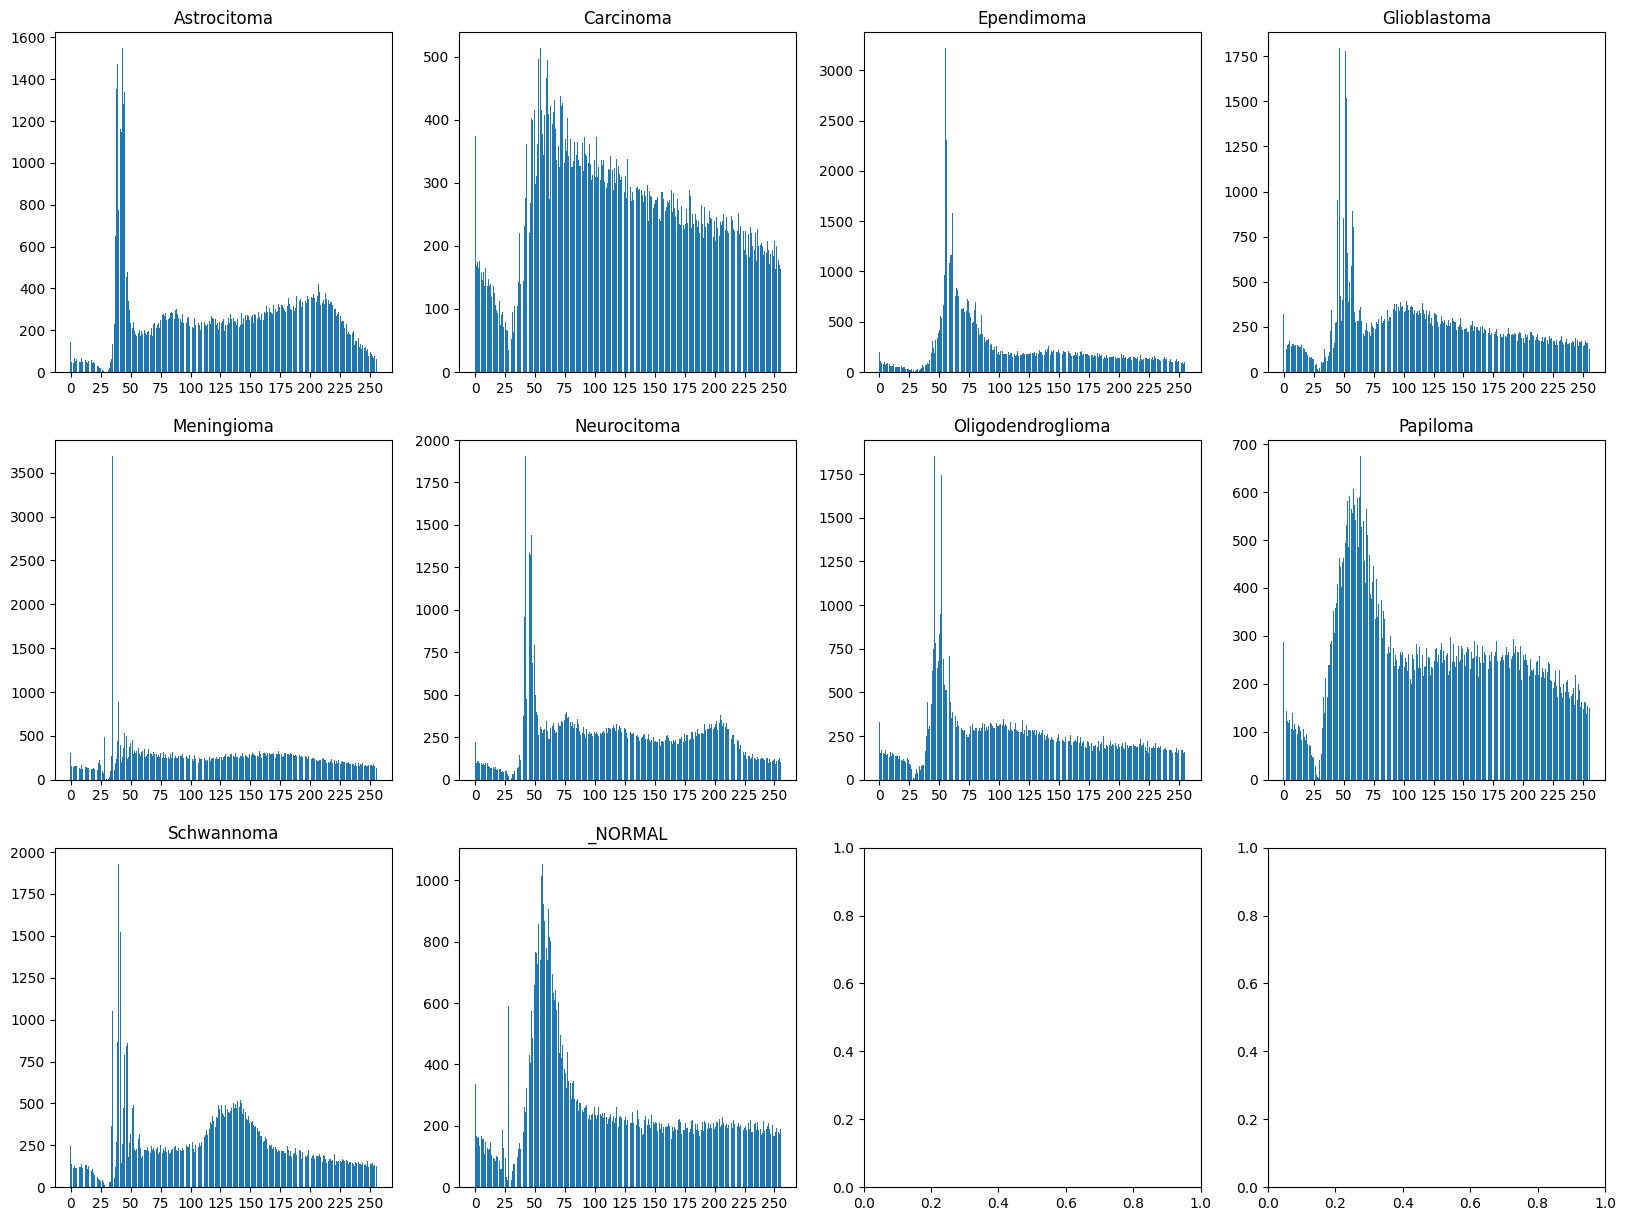

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
data_path = os.path.join(root_path, "contrast_streched_shortened_dataset")
image_dict = json.load(open(os.path.join(data_path, 'image_dict.json'), 'r'))
visualize_histogram_per_class(image_dict, data_path)

#### Segmentation

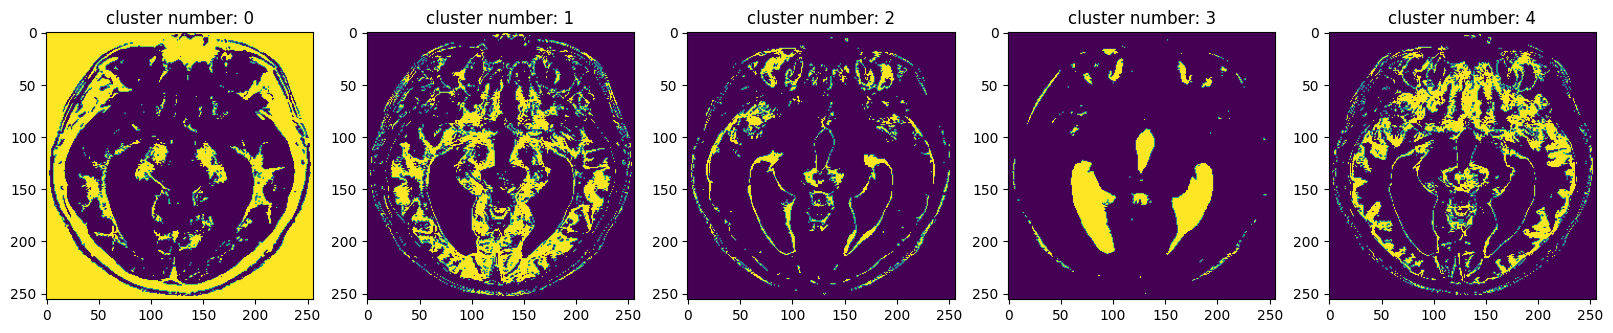

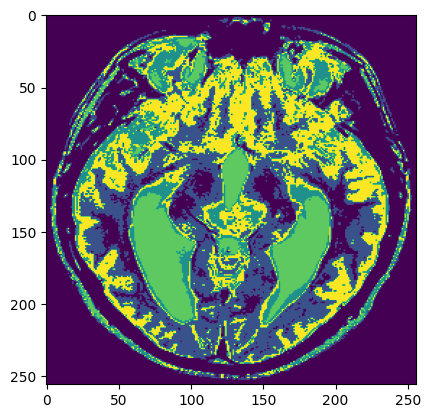

In [9]:
image = cv2.imread('/media/khoa-ys/Personal/Projects/ML in Bioinformatics/brain-tumor-classification/contrast_streched_combined_dataset/Germinoma/0d48674d5a373850260abe289e2744_big_gallery.png',
                   cv2.IMREAD_GRAYSCALE)
n_clusters = 5

segmented_image = fuzzy_c_means(image, n_clusters, visualize=True)
plt.figure()
plt.imshow(segmented_image)

In [10]:
n_clusters = 5
new_data_path = os.path.join(root_path, "segmented_shortened_dataset")
if not os.path.exists(new_data_path):
    os.mkdir(new_data_path)
    
new_image_dict = {}
for i in range(len(image_dict.keys())):
    tumor_type = list(image_dict.keys())[i]
    new_name_list = []
    for image_name in image_dict[tumor_type]:
        image_path = os.path.join(data_path, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        segmented_image = fuzzy_c_means(image, n_clusters, visualize=False)
        
        dest = os.path.join(new_data_path, image_name.split('/')[0].split(' ')[0])
        if not os.path.exists(dest):
            os.mkdir(dest)
            
        new_image_name = image_name.split('/')[1]
        
        cv2.imwrite(os.path.join(dest, new_image_name), segmented_image*63)
        new_name_list.append(image_name.split('/')[0] + '/' + new_image_name)
    new_image_dict[tumor_type] = new_name_list

json.dump(new_image_dict, open(os.path.join(new_data_path, "image_dict.json"), "w"))    

/media/khoa-ys/Personal/Projects/ML in Bioinformatics/brain-tumor-classification/src/FCM.py:58: RuntimeWarning: divide by zero encountered in divide
  p2 = np.sum((1./abs(idx_mesh-c_mesh))**power,axis=1)
/media/khoa-ys/Personal/Projects/ML in Bioinformatics/brain-tumor-classification/src/FCM.py:60: RuntimeWarning: invalid value encountered in multiply
  return 1./(p1*p2[:,None])


#### DWT transformation

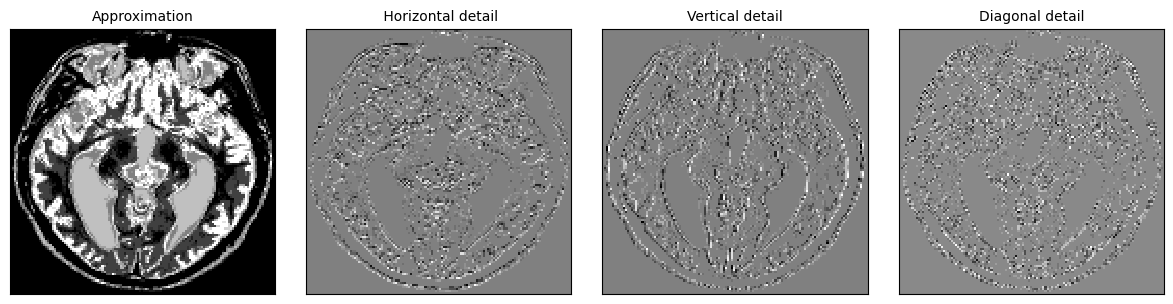

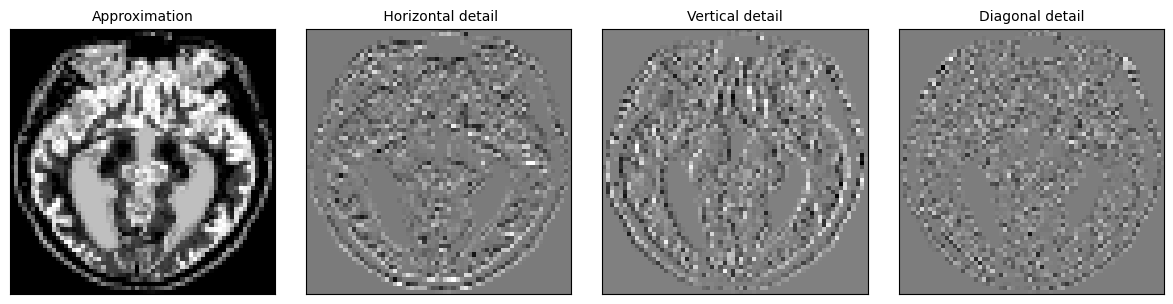

array([0., 0., 0., ..., 0., 0., 0.])

In [11]:
image = cv2.imread('/media/khoa-ys/Personal/Projects/ML in Bioinformatics/brain-tumor-classification/segmented_combined_dataset/Germinoma/0d48674d5a373850260abe289e2744_big_gallery.png',
                   cv2.IMREAD_GRAYSCALE)
transformed_image = dwt_transform(image, visualize=True)
transformed_image.flatten()

In [12]:
data_path = os.path.join(root_path, "segmented_shortened_dataset")
image_dict = json.load(open(os.path.join(data_path, 'image_dict.json'), 'r'))

new_data_path = os.path.join(root_path, "dwt_shortened_dataset")
if not os.path.exists(new_data_path):
    os.mkdir(new_data_path)
    
new_image_dict = {}
image_value_dict = {}
for i in range(len(image_dict.keys())):
    tumor_type = list(image_dict.keys())[i]
    new_name_list = []
    value_list = []
    for image_name in image_dict[tumor_type]:
        image_path = os.path.join(data_path, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        transformed_image = dwt_transform(image, visualize=False)
        
        transformed_image = transformed_image.flatten()
        value_list.append(transformed_image)
        
    new_image_dict[tumor_type] = new_name_list
    image_value_dict[tumor_type] = np.array(value_list)
json.dump(new_image_dict, open(os.path.join(new_data_path, "image_dict.json"), "w"))  

In [13]:
key, all_values_list = list(image_value_dict.items())[0]
key_dict = dict(zip(list(image_value_dict.keys()), range(1, 16)))
all_key_list = [key for i in range(len(all_values_list))]

for k, v in list(image_value_dict.items())[1:]:
    for i in range(len(v)):
        all_key_list.append(k)
    all_values_list = np.concatenate((all_values_list, v), axis=0)

data = pd.DataFrame(all_values_list)
data['label'] = all_key_list
data.to_csv(os.path.join(new_data_path, "image_value_dict.csv"), index=False)
data

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,label
0,252.0,252.0,252.0,252.0,252.00,252.0,252.0,252.0,252.0,252.00,...,252.00,252.00,252.0,252.0,252.0,252.0,252.00,252.00,252.0,Astrocitoma
1,504.0,504.0,504.0,504.0,535.50,567.0,504.0,504.0,504.0,504.00,...,504.00,504.00,504.0,504.0,504.0,504.0,504.00,504.00,504.0,Astrocitoma
2,504.0,504.0,504.0,504.0,504.00,504.0,504.0,504.0,504.0,504.00,...,504.00,504.00,504.0,504.0,504.0,504.0,504.00,504.00,504.0,Astrocitoma
3,1008.0,1008.0,1008.0,1008.0,1008.00,1008.0,1008.0,1008.0,1008.0,1008.00,...,1008.00,1008.00,1008.0,1008.0,1008.0,1008.0,1008.00,1008.00,1008.0,Astrocitoma
4,504.0,504.0,504.0,504.0,504.00,504.0,504.0,504.0,504.0,504.00,...,504.00,504.00,504.0,504.0,504.0,504.0,504.00,504.00,504.0,Astrocitoma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2561,1008.0,1008.0,1008.0,1008.0,960.75,1008.0,1008.0,1008.0,1008.0,1008.00,...,1008.00,1008.00,1008.0,1008.0,1008.0,1008.0,960.75,1008.00,1008.0,_NORMAL
2562,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,...,0.00,15.75,0.0,0.0,0.0,0.0,47.25,0.00,0.0,_NORMAL
2563,504.0,504.0,504.0,504.0,504.00,504.0,504.0,504.0,504.0,504.00,...,488.25,504.00,504.0,472.5,504.0,504.0,504.00,488.25,504.0,_NORMAL
2564,504.0,504.0,504.0,504.0,504.00,504.0,504.0,504.0,504.0,504.00,...,504.00,504.00,504.0,504.0,504.0,504.0,504.00,504.00,504.0,_NORMAL
